In [2]:
import os
import gzip
import glob
import h5py
#import torch
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
#import plotly as pt
#import plotly.graph_objs as go
#import plotly.express as px
import scanpy as sc
import mira

/media/RAIDArray/Nick/miniconda3/envs/mira-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import logging
import warnings
#mira.utils.pretty_sderr()

In [2]:
#mira.__version__,torch.__version__

('2.1.0', '1.13.0+cu117')

In [4]:
# %config Completer.use_jedi = False

In [6]:
# %matplotlib inline

In [7]:
torch.cuda.is_available()

True

In [8]:
# for i in range(torch.cuda.device_count()):
#     print(torch.cuda.get_device_properties(i).name)

NVIDIA A100-PCIE-40GB


In [9]:
# torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA A100-PCIE-40GB', major=8, minor=0, total_memory=40396MB, multi_processor_count=108)

In [2]:
!pwd

/media/RAIDArray/Nick/jupyter/primary_Bcell_perturbation_scRNAseq


In [3]:
mira

<module 'mira' from '/home/nick/miniconda3/envs/jupyter/lib/python3.9/site-packages/mira/__init__.py'>

# merge samples

In [ ]:
filenames = glob.glob("/ix/djishnu/Common_Folder/Jingyu_Data/20231110_PerturbSeq/demultiplexed_samples_240109/outs/per_sample_outs/*/count/sample_filtered_feature_bc_matrix.h5")

adatas=[]
for filename in filenames:
    adatas.append(sc.read_10x_h5(filename))
    adatas[-1].var_names_make_unique()
    adatas[-1].obs['group']=filename.split('/')[-3]

adata = adatas[0].concatenate(adatas[1:],index_unique=None)

In [ ]:
adata.var_names_make_unique()

In [ ]:
adata

In [ ]:
adata.obs

In [ ]:
adata.var

In [ ]:
adata.var.index.to_list()[-12:]

In [ ]:
adata.write('/ix/djishnu/Common_Folder/Jingyu_Data/20231110_PerturbSeq/demultiplexed_samples_240109/results/multiplexed_perturbation_scRNAseq_20231117_merged.h5ad')



In [ ]:
adata[:,('D4_BATF',
         'D4_IRF4',
         'D4_IRF8',
         'D4_NTC',
         'D4_PRDM1',
         'D4_SPI1',
         'D6_BATF',
         'D6_IRF4',
         'D6_IRF8',
         'D6_NTC',
         'D6_PRDM1',
         'D6_SPI1')].to_df()

In [15]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=20)

In [16]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')

In [17]:
adata

AnnData object with n_obs × n_vars = 40459 × 19911
    obs: 'group', 'batch', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells', 'mt'

In [18]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

... storing 'group' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'pattern' as categorical
... storing 'read' as categorical
... storing 'sequence' as categorical


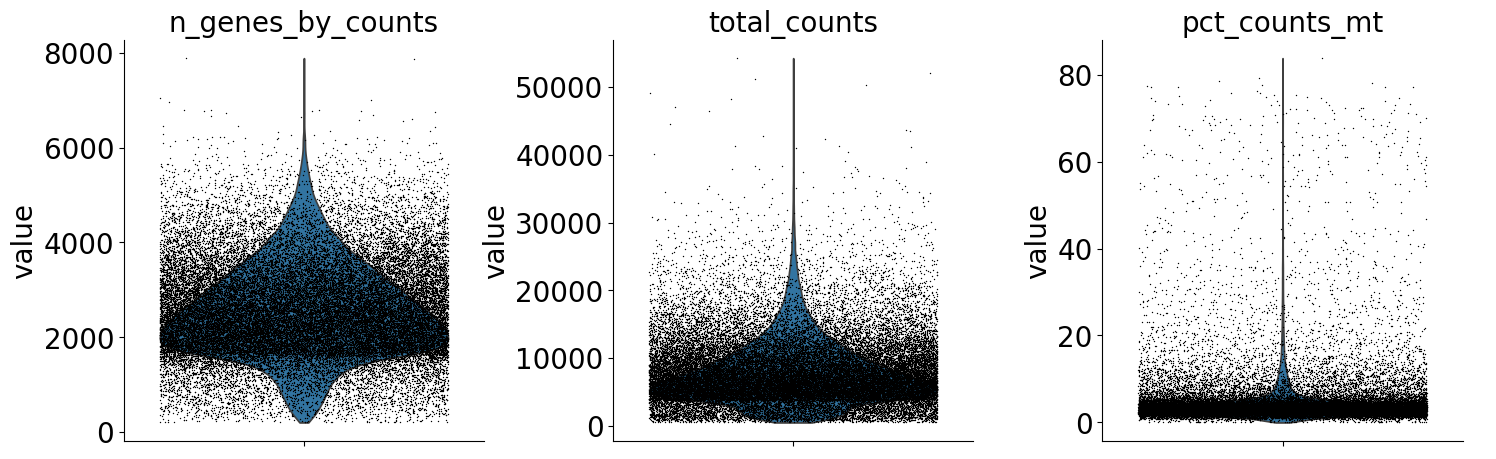

In [19]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4,
             multi_panel=True
            )

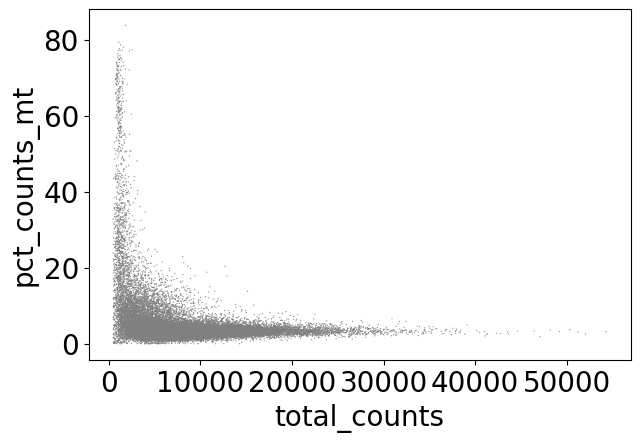

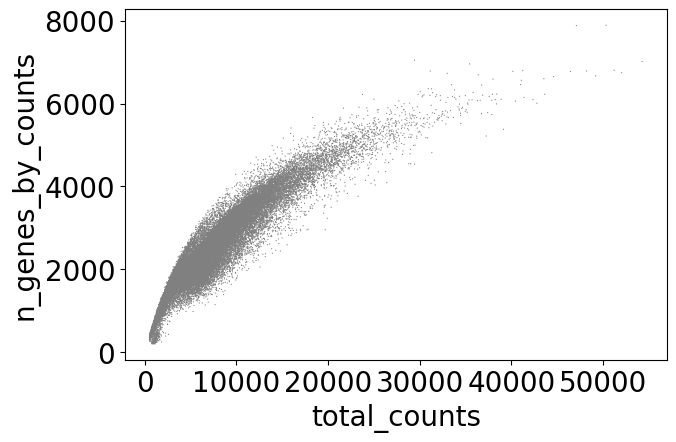

In [20]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [21]:
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]

In [22]:
adata

View of AnnData object with n_obs × n_vars = 37709 × 19911
    obs: 'group', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

# MIRA

In [10]:
adata=sc.read_h5ad("/ix/djishnu/Common_Folder/Jingyu_Data/20231110_PerturbSeq/demultiplexed_samples_240109/results/human_B_cell_20231110_PerturbSeq_scRNA_240118.merged.h5ad")

In [11]:
rawdata = adata.X.copy()

In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [13]:
adata.layers['counts'] = rawdata

In [14]:
sc.pp.highly_variable_genes(adata, min_disp = 0.2)

In [15]:
# sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pp.highly_variable_genes(adata, min_disp = 0.2)

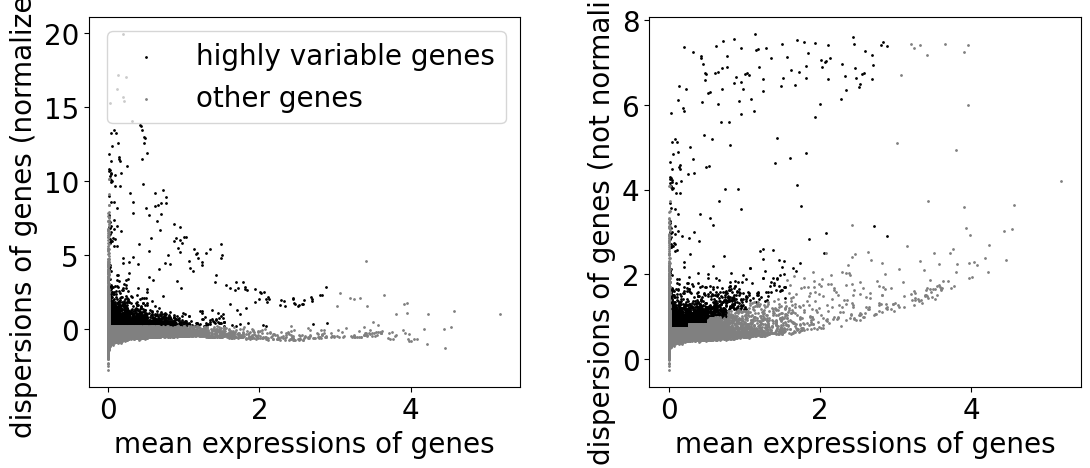

In [16]:
sc.pl.highly_variable_genes(adata)

In [17]:
adata

AnnData object with n_obs × n_vars = 37709 × 19911
    obs: 'group', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [18]:
adata.var['highly_variable'].value_counts()

highly_variable
False    16666
True      3245
Name: count, dtype: int64

In [21]:
adata.write('/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/gene_data_240729.merged.h5ad')

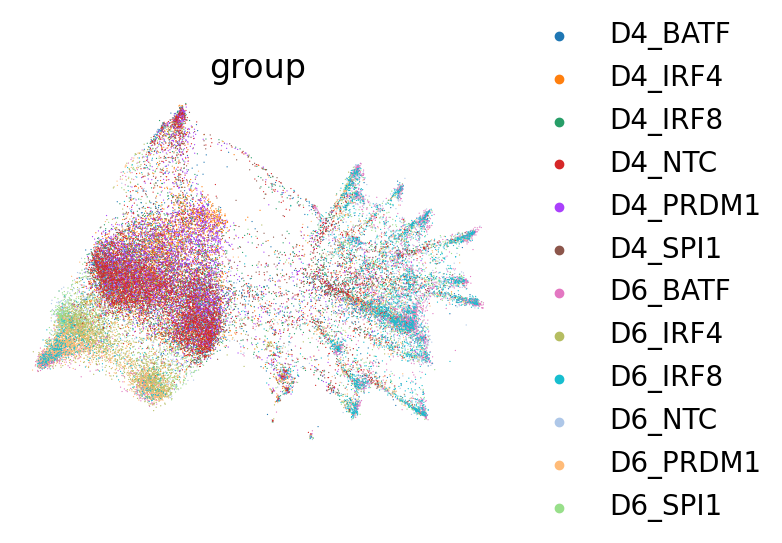

In [31]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=50)
sc.tl.umap(adata, min_dist = 0.2, negative_sample_rate=0.2)
sc.pl.umap(adata, color = 'group', frameon=False)

In [32]:
model = mira.topics.make_model(
    adata.n_obs, adata.n_vars, # helps MIRA choose reasonable values for some hyperparameters which are not tuned.
    feature_type = 'expression',
    highly_variable_key='highly_variable',
    counts_layer='counts',
#     categorical_covariates='batch'
)

In [33]:
model.get_learning_rate_bounds(adata)

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: highly_variable


Learning rate range test:   0%|          | 0/98 [00:00<?, ?it/s]

/ix/djishnu/peasena/miniconda3/envs/mira-env/lib/python3.9/site-packages/pyro/poutine/trace_struct.py:321: UserWarning: Encountered NaN: log_prob_sum at site 'rna/theta'
  warn_if_nan(
INFO:mira.topic_model.base:Set learning rates to: (5.2940207866433455e-06, 0.3743164765633498)


(5.2940207866433455e-06, 0.3743164765633498)

<Axes: xlabel='Learning Rate', ylabel='Loss'>

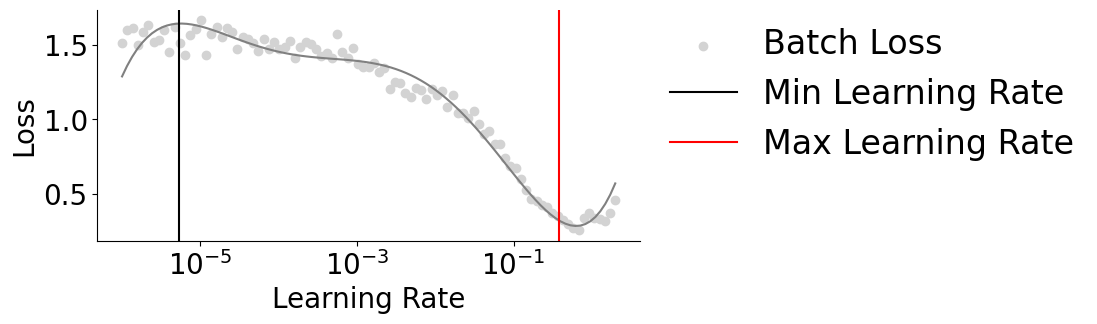

In [34]:
model.plot_learning_rate_bounds(figsize=(7,3))

In [35]:
model.set_learning_rates(1e-3, 0.2)

#  Hyperparameter Optimization: Gradient based

In [36]:
topic_contributions = mira.topics.gradient_tune(model, adata)

Training model:   0%|          | 0/24 [00:00<?, ?it/s]

Predicting latent vars:   0%|          | 0/148 [00:00<?, ?it/s]

In [40]:
with open('/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/topic_contributions.txt', 'w') as file:
    file.write('\n'.join(str(topic) for topic in topic_contributions))

<Axes: xlabel='Topic Number', ylabel='Max contribution'>

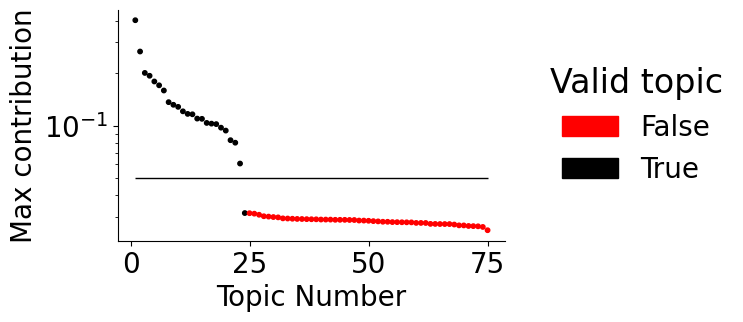

In [41]:
NUM_TOPICS = 24

mira.pl.plot_topic_contributions(topic_contributions, NUM_TOPICS)

In [43]:
model = model.set_params(num_topics = NUM_TOPICS).fit(adata)

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: highly_variable


Training model:   0%|          | 0/24 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Moving model to device: cpu


In [45]:
model.save('/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/mira_model_240401_gradient.pth')

# Hyperparameter Optimization: Bayesian

In [49]:
tuner = mira.topics.BayesianTuner(
        model = model,
        n_jobs=2,
        save_name = '/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/expression_model_tuner',
        #### IMPORTANT
        min_topics = 16, max_topics = 50, # tailor for your dataset!!!!
        #### See "Notes on min_topics, max_topics" above
        #storage = mira.topics.Redis() # if using REDIS backend for more (>5) processes
)

In [50]:
dir(tuner)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_set_failed',
 'basemodel_path',
 'create_study',
 'fetch_best_weights',
 'fetch_weights',
 'fit',
 'get_pruner',
 'get_stop_callback',
 'get_tuner',
 'iters',
 'load',
 'log_every',
 'log_steps',
 'max_topics',
 'min_topics',
 'min_trials',
 'model',
 'model_dir',
 'n_completed_trials',
 'n_jobs',
 'objective',
 'optimize',
 'parallel',
 'parallel_dashboard',
 'plot_intermediate_values',
 'plot_pareto_front',
 'pruner',
 'purge',
 'sampler',
 'seed',
 'serial_dashboard',
 'stop_condition',
 'storage',
 'study',
 'study_name',
 'tensorboard_logdir',
 'train_size',
 'train_test_split',
 'trial_attrs']

In [51]:
tuner.fit(adata)

INFO:mira.topic_model.hyperparameter_optim.trainer:Deleting cache ...


Trials finished: 6 | Best trial: 0 | Best score: 1.3665e+03
Press ctrl+C,ctrl+C or esc,I+I,I+I in Jupyter notebook to stop early.

Tensorboard logidr: /ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/expression_model_tuner
#Topics | #Trials 

     22 | ■ 
     43 | ■ 

Trial | Result (● = best so far)         | Params
 #0   | ● | completed, score: 1.3665e+03 | {'decoder_dropout': 0.0519, 'num_topics': 22}
 #1   |   | completed, score: 1.3674e+03 | {'decoder_dropout': 0.0592, 'num_topics': 43}

Running trials:
Trial | Progress                         | Params
 #2   |■■■■■■■■■■■■■■■■■■■■■             | {'decoder_dropout': 0.0573, 'num_topics': 22}
 #3   |■■■■■■■■■■■■■■■■■■■■■             | {'decoder_dropout': 0.0527, 'num_topics': 23}
 #4   |                                  | {'decoder_dropout': 0.0513, 'num_topics': 49}
 #5   |                                  | {'decoder_dropout': 0.0629, 'num_topics': 46}




dirichlet_expression_model(
  (decoder): Decoder(
    (beta): Linear(in_features=22, out_features=3245, bias=False)
    (bn): BatchNorm1d(3245, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop1): Dropout(p=0.05, inplace=False)
    (drop2): Dropout(p=0.051857663004193595, inplace=False)
  )
  (encoder): ExpressionEncoder(
    (fc_layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=3246, out_features=512, bias=False)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.01, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=False)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.01, inplace=False)
      )
      (2): Sequential(
        (0): Linear(in_features=512, out_features=46, bias=False)
        (1): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
)

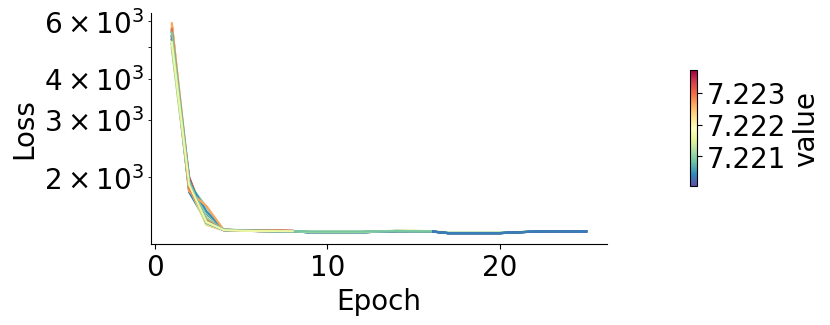

In [30]:
ax = tuner.plot_intermediate_values(palette='Spectral_r',
                                   log_hue=True, figsize=(7,3))
# ax.set(ylim = (7e2, 7.7e2))

<AxesSubplot: xlabel='Num_topics', ylabel='Elbo'>

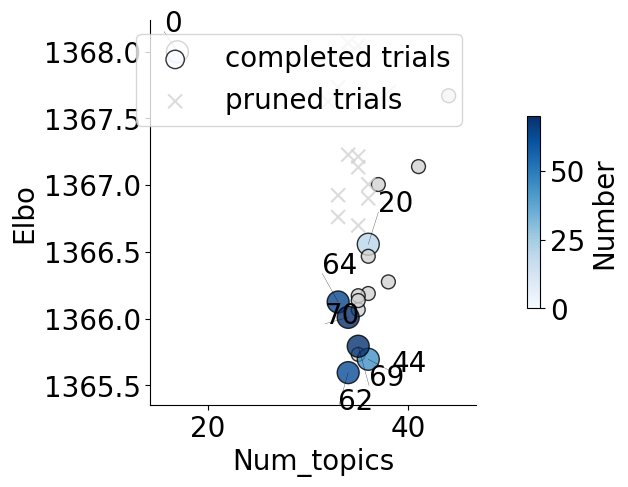

In [31]:
tuner.plot_pareto_front(include_pruned_trials=False, label_pareto_front=True,
                       figsize = (5,5))

In [32]:
model = tuner.fetch_best_weights()

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [38]:
model.save('/ix/djishnu/Common_Folder/Pease_Data/Jingyu_Data/20231110_PerturbSeq/demultiplexed_samples_240109/results/mira_model_240118.pth')

In [5]:
#load model
model = mira.topic_model.load_model('/ix/djishnu/Common_Folder/Jingyu_Data/20231110_PerturbSeq/demultiplexed_samples_240109/results/mira_model_240118.pth')


/ix/djishnu/peasena/miniconda3/envs/mira-env/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/ix/djishnu/peasena/miniconda3/envs/mira-env/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [22]:
#reload adata if needed
adata=sc.read_h5ad('/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/gene_data_240729.merged.h5ad')

In [23]:
adata

AnnData object with n_obs × n_vars = 37709 × 19911
    obs: 'group', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
    layers: 'counts'

In [10]:
model

dirichlet_expression_model(
  (decoder): Decoder(
    (beta): Linear(in_features=34, out_features=3245, bias=False)
    (bn): BatchNorm1d(3245, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop1): Dropout(p=0.05, inplace=False)
    (drop2): Dropout(p=0.05300928058957012, inplace=False)
  )
  (encoder): ExpressionEncoder(
    (fc_layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=3246, out_features=512, bias=False)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.01, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=False)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.01, inplace=False)
      )
      (2): Sequential(
        (0): Linear(in_features=512, out_features=70, bias=False)
        (1): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
)

In [24]:
model.predict(adata)

Predicting latent vars:   0%|          | 0/148 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30, topic_31, topic_32, topic_33
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram


In [29]:
model.get_umap_features(adata, box_cox=0.5)
sc.pp.neighbors(adata, use_rep = 'X_umap_features', metric = 'manhattan',n_neighbors=20)
sc.tl.umap(adata, min_dist=0.25, negative_sample_rate=5,random_state=0)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


In [4]:
sc.tl.leiden(adata,resolution=0.15,random_state=6)

/scratch/slurm-3938782/ipykernel_42841/192992495.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata,resolution=0.15,random_state=6)


In [5]:
adata.uns['leiden_colors'] = ['dodgerblue', 'firebrick', 'green', 'black']

<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

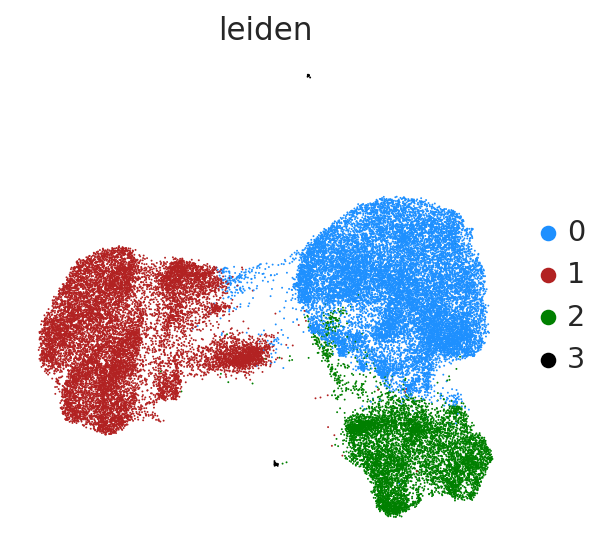

In [6]:
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(5,5)})

sc.set_figure_params(scanpy=True, fontsize=14, dpi_save = 350)

sc.pl.umap(adata, color=['leiden'], s = 3, show=False, frameon=False)

#plt.savefig("/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/umap_leiden.pdf")

In [7]:
adata.write('/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/gene_data_240729.merged_topics.h5ad')

# part II start

In [16]:
adata=sc.read_h5ad("/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/gene_data_240729.merged_topics.h5ad")


<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

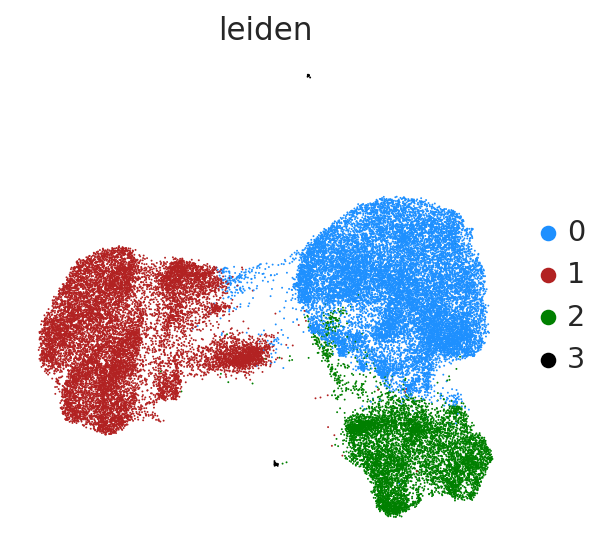

In [17]:
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(5,5)})

sc.set_figure_params(scanpy=True, fontsize=14, dpi_save = 350)

sc.pl.umap(adata, color=['leiden'], s = 3, show=False, frameon=False)


In [18]:
# Create a mapping dictionary for leiden annotations
leiden_mapping = {
    '0': 'ActB',
    '1': 'PB',
    '2': 'GC',
    '3': 'NA'
}

# Create the new 'leiden_annotation' column by mapping the 'leiden' column
adata.obs['cell_type_annotation'] = adata.obs['leiden'].map(leiden_mapping)

In [19]:
adata

AnnData object with n_obs × n_vars = 37709 × 19911
    obs: 'group', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'topic_32', 'topic_33', 'leiden', 'day', 'knockout', 'cell_type_annotation'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'topic_dendogram', 'umap'
    obsm: 'X_topic_compositions', 'X_umap', 'X_umap_features'
    varm: 'topic_feature_activa

In [20]:
adata.obs['replicate'] = 'Rep1'

In [21]:
adata.obs['leiden_filtered_cells'] = ~adata.obs['leiden'].isin(["3"])
adata.obs['leiden_filtered_cells'].value_counts()

leiden_filtered_cells
True     37658
False       51
Name: count, dtype: int64

In [22]:
adata.obs['sample'] = adata.obs['group']

# Remove specified slots from adata.obs
slots_to_remove = [
    'group'
]

# Create a new AnnData object without the specified columns
adata.obs = adata.obs.drop(columns=slots_to_remove, errors='ignore')

... storing 'replicate' as categorical


[<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'cell_type_annotation'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'sample'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'replicate'}, xlabel='UMAP1', ylabel='UMAP2'>]

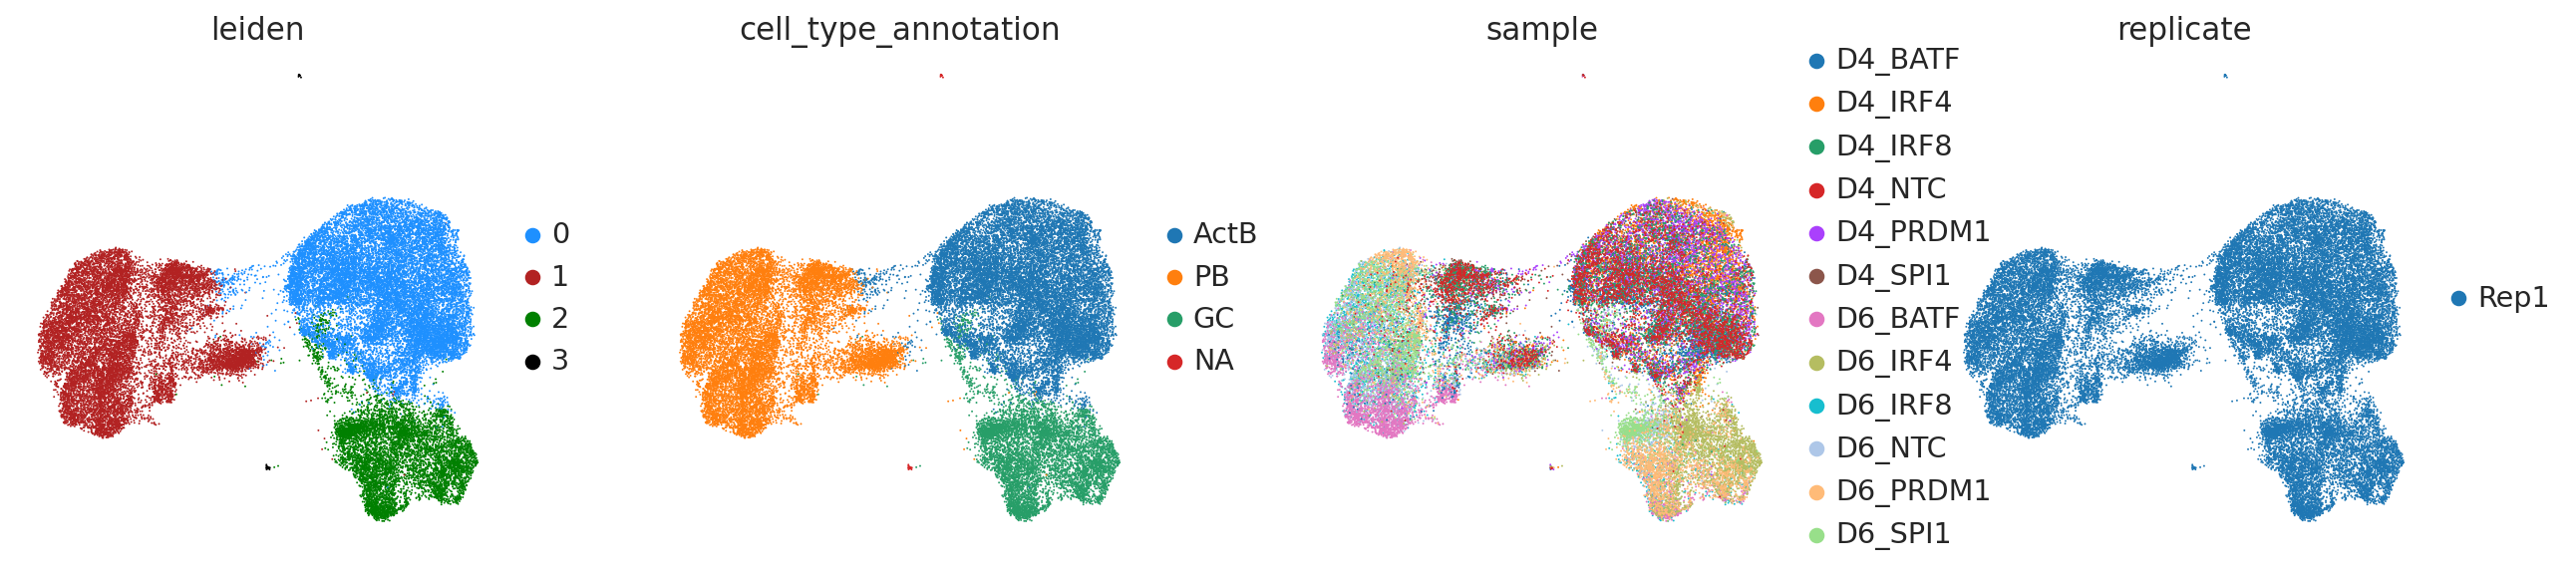

In [23]:
sc.pl.umap(adata, color=['leiden', "cell_type_annotation", "sample", "replicate"], s = 3, show=False, frameon=False, cmap='inferno')

In [24]:
adata.write('/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/h5_files/tf_perturbseq_rep1_post_mira.h5ad')

In [3]:
adata = sc.read_h5ad("/media/RAIDArray/Nick/projects/human_Bcell_GRN/20231110_PerturbSeq_Exp1/h5_files/tf_perturbseq_rep1_post_mira.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 37709 × 19911
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'topic_32', 'topic_33', 'leiden', 'day', 'knockout', 'cell_type_annotation', 'replicate', 'leiden_filtered_cells', 'sample'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_annotation_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'replicate_colors', 'sample_colors', 'topic_dendo

In [6]:
adata.obs['n_genes_by_counts']

AAACCTGAGCAGACTG-1    2060
AAACCTGAGGATGCGT-1    2615
AAACCTGCAGTCTTCC-1    3275
AAACGGGAGAAACCTA-1    2258
AAACGGGAGCAGACTG-1    1504
                      ... 
TTTGTCAGTCACTGGC-1    2588
TTTGTCAGTTTGCATG-1    2338
TTTGTCATCGCCGTGA-1    2255
TTTGTCATCGGAAATA-1    2317
TTTGTCATCGGAATCT-1    1938
Name: n_genes_by_counts, Length: 37709, dtype: int32

In [8]:
adata.obs['total_counts']

AAACCTGAGCAGACTG-1     6296.0
AAACCTGAGGATGCGT-1     9057.0
AAACCTGCAGTCTTCC-1    11161.0
AAACGGGAGAAACCTA-1     8646.0
AAACGGGAGCAGACTG-1     5400.0
                       ...   
TTTGTCAGTCACTGGC-1     5977.0
TTTGTCAGTTTGCATG-1     5571.0
TTTGTCATCGCCGTGA-1     6442.0
TTTGTCATCGGAAATA-1     6007.0
TTTGTCATCGGAATCT-1     4842.0
Name: total_counts, Length: 37709, dtype: float32

In [5]:
#get cell numbers per cluster
cell_numbers = adata.obs.groupby(["leiden_annotation", "group"]).apply(len)

cell_numbers

/scratch/slurm-4682469/ipykernel_22187/981007380.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_numbers = adata.obs.groupby(["leiden_annotation", "group"]).apply(len)
/scratch/slurm-4682469/ipykernel_22187/981007380.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cell_numbers = adata.obs.groupby(["leiden_annotation", "group"]).apply(len)


leiden_annotation  group   
ActB               D4_BATF     1823
                   D4_IRF4     2863
                   D4_IRF8     2616
                   D4_NTC      3215
                   D4_PRDM1    3191
                   D4_SPI1     2323
                   D6_BATF       22
                   D6_IRF4      265
                   D6_IRF8       27
                   D6_NTC       132
                   D6_PRDM1      70
                   D6_SPI1      112
PB                 D4_BATF      691
                   D4_IRF4      155
                   D4_IRF8      771
                   D4_NTC       811
                   D4_PRDM1     332
                   D4_SPI1      717
                   D6_BATF     2492
                   D6_IRF4      362
                   D6_IRF8     2653
                   D6_NTC      2125
                   D6_PRDM1     945
                   D6_SPI1     1721
preGC              D4_BATF       17
                   D4_IRF4       35
                   D4_IRF8       18


In [6]:
cell_numbers.to_csv('/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/cell_numbers_241217.csv')

# DEG analysis

In [8]:
adata_actB=adata[adata.obs['leiden']=='0'].copy()
adata_GC=adata[adata.obs['leiden']=='2'].copy()
adata_PB=adata[adata.obs['leiden']=='1'].copy()

In [18]:
adata_actB.obs['group']

ACATACGGTCGATTGT-1    D6_IRF8
AGAGTGGGTCATCCCT-1    D6_IRF8
CAAGAAACATCGACGC-1    D6_IRF8
CACACTCAGGATATAC-1    D6_IRF8
CACAGGCGTTATGTGC-1    D6_IRF8
                       ...   
TTTGTCAGTCACTGGC-1     D4_NTC
TTTGTCAGTTTGCATG-1     D4_NTC
TTTGTCATCGCCGTGA-1     D4_NTC
TTTGTCATCGGAAATA-1     D4_NTC
TTTGTCATCGGAATCT-1     D4_NTC
Name: group, Length: 16659, dtype: category
Categories (12, object): ['D4_BATF', 'D4_IRF4', 'D4_IRF8', 'D4_NTC', ..., 'D6_IRF8', 'D6_NTC', 'D6_PRDM1', 'D6_SPI1']

In [18]:
adata_actB_batf=adata_actB[adata_actB.obs['group'].isin(['D4_BATF', 'D4_NTC'])].copy()

adata_actB_irf4=adata_actB[adata_actB.obs['group'].isin(['D4_IRF4', 'D4_NTC'])].copy()

adata_actB_irf8=adata_actB[adata_actB.obs['group'].isin(['D4_IRF8', 'D4_NTC'])].copy()

adata_actB_prdm1=adata_actB[adata_actB.obs['group'].isin(['D4_PRDM1', 'D4_NTC'])].copy()

In [19]:
adata_GC_batf=adata_GC[adata_GC.obs['group'].isin(['D6_BATF', 'D6_NTC'])].copy()

adata_GC_irf4=adata_GC[adata_GC.obs['group'].isin(['D6_IRF4', 'D6_NTC'])].copy()

adata_GC_irf8=adata_GC[adata_GC.obs['group'].isin(['D6_IRF8', 'D6_NTC'])].copy()

adata_GC_prdm1=adata_GC[adata_GC.obs['group'].isin(['D6_PRDM1', 'D6_NTC'])].copy()

In [20]:
adata_PB_batf=adata_PB[adata_PB.obs['group'].isin(['D4_BATF', 'D4_NTC'])].copy()

adata_PB_irf4=adata_PB[adata_PB.obs['group'].isin(['D4_IRF4', 'D4_NTC'])].copy()

adata_PB_irf8=adata_PB[adata_PB.obs['group'].isin(['D4_IRF8', 'D4_NTC'])].copy()

adata_PB_prdm1=adata_PB[adata_PB.obs['group'].isin(['D4_PRDM1', 'D4_NTC'])].copy()

In [21]:
sc.tl.rank_genes_groups(adata_actB_batf, 'group', key_added='deg_d4_batf',
                        method='t-test_overestim_var',use_raw=False,pts=True)

sc.tl.rank_genes_groups(adata_actB_irf4, 'group', key_added='deg_d4_irf4',
                        method='t-test_overestim_var',use_raw=False,pts=True)

sc.tl.rank_genes_groups(adata_actB_irf8, 'group', key_added='deg_d4_irf8',
                        method='t-test_overestim_var',use_raw=False,pts=True)

sc.tl.rank_genes_groups(adata_actB_prdm1, 'group', key_added='deg_d4_prdm1',
                        method='t-test_overestim_var',use_raw=False,pts=True)



In [22]:
sc.tl.rank_genes_groups(adata_GC_batf, 'group', key_added='deg_GC_batf',
                        method='t-test_overestim_var',use_raw=False,pts=True)

sc.tl.rank_genes_groups(adata_GC_irf4, 'group', key_added='deg_GC_irf4',
                        method='t-test_overestim_var',use_raw=False,pts=True)

sc.tl.rank_genes_groups(adata_GC_irf8, 'group', key_added='deg_GC_irf8',
                        method='t-test_overestim_var',use_raw=False,pts=True)

sc.tl.rank_genes_groups(adata_GC_prdm1, 'group', key_added='deg_GC_prdm1',
                        method='t-test_overestim_var',use_raw=False,pts=True)


In [23]:
sc.tl.rank_genes_groups(adata_PB_batf, 'group', key_added='deg_PB_batf',
                        method='t-test_overestim_var',use_raw=False,pts=True)

sc.tl.rank_genes_groups(adata_PB_irf4, 'group', key_added='deg_PB_irf4',
                        method='t-test_overestim_var',use_raw=False,pts=True)

sc.tl.rank_genes_groups(adata_PB_irf8, 'group', key_added='deg_PB_irf8',
                        method='t-test_overestim_var',use_raw=False,pts=True)

sc.tl.rank_genes_groups(adata_PB_prdm1, 'group', key_added='deg_PB_prdm1',
                        method='t-test_overestim_var',use_raw=False,pts=True)


In [24]:
df_de_gene = sc.get.rank_genes_groups_df(adata_actB_batf, group=None, key="deg_d4_batf")
df_de_gene.to_csv('/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/DEG/deg_d4_batf.csv',header=True,index=False)

df_de_gene = sc.get.rank_genes_groups_df(adata_actB_irf4, group=None, key="deg_d4_irf4")
df_de_gene.to_csv('/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/DEG/deg_d4_irf4.csv',header=True,index=False)

df_de_gene = sc.get.rank_genes_groups_df(adata_actB_irf8, group=None, key="deg_d4_irf8")
df_de_gene.to_csv('/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/DEG/deg_d4_irf8.csv',header=True,index=False)

df_de_gene = sc.get.rank_genes_groups_df(adata_actB_prdm1, group=None, key="deg_d4_prdm1")
df_de_gene.to_csv('/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/DEG/deg_d4_prdm1.csv',header=True,index=False)


In [25]:
df_de_gene = sc.get.rank_genes_groups_df(adata_GC_batf, group=None, key="deg_GC_batf")
df_de_gene.to_csv('/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/DEG/deg_GC_batf.csv',header=True,index=False)

df_de_gene = sc.get.rank_genes_groups_df(adata_GC_irf4, group=None, key="deg_GC_irf4")
df_de_gene.to_csv('/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/DEG/deg_GC_irf4.csv',header=True,index=False)

df_de_gene = sc.get.rank_genes_groups_df(adata_GC_irf8, group=None, key="deg_GC_irf8")
df_de_gene.to_csv('/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/DEG/deg_GC_irf8.csv',header=True,index=False)

df_de_gene = sc.get.rank_genes_groups_df(adata_GC_prdm1, group=None, key="deg_GC_prdm1")
df_de_gene.to_csv('/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/DEG/deg_GC_prdm1.csv',header=True,index=False)


In [26]:
df_de_gene = sc.get.rank_genes_groups_df(adata_PB_batf, group=None, key="deg_PB_batf")
df_de_gene.to_csv('/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/DEG/deg_PB_batf.csv',header=True,index=False)

df_de_gene = sc.get.rank_genes_groups_df(adata_PB_irf4, group=None, key="deg_PB_irf4")
df_de_gene.to_csv('/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/DEG/deg_PB_irf4.csv',header=True,index=False)

df_de_gene = sc.get.rank_genes_groups_df(adata_PB_irf8, group=None, key="deg_PB_irf8")
df_de_gene.to_csv('/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/DEG/deg_PB_irf8.csv',header=True,index=False)

df_de_gene = sc.get.rank_genes_groups_df(adata_PB_prdm1, group=None, key="deg_PB_prdm1")
df_de_gene.to_csv('/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/DEG/deg_PB_prdm1.csv',header=True,index=False)


# umaps

In [67]:
# add day
cond = []
for x in adata.obs.group:
    x = x[0:2]
    if x == 'D4':
        cond.append('D4')
    elif x == 'D6':
        cond.append('D6')

adata.obs['day'] = cond

In [69]:
adata.obs['day']

AAACCTGAGCAGACTG-1    D6
AAACCTGAGGATGCGT-1    D6
AAACCTGCAGTCTTCC-1    D6
AAACGGGAGAAACCTA-1    D6
AAACGGGAGCAGACTG-1    D6
                      ..
TTTGTCAGTCACTGGC-1    D4
TTTGTCAGTTTGCATG-1    D4
TTTGTCATCGCCGTGA-1    D4
TTTGTCATCGGAAATA-1    D4
TTTGTCATCGGAATCT-1    D4
Name: day, Length: 37709, dtype: object

In [77]:
adata.obs['group']

AAACCTGAGCAGACTG-1    D6_IRF8
AAACCTGAGGATGCGT-1    D6_IRF8
AAACCTGCAGTCTTCC-1    D6_IRF8
AAACGGGAGAAACCTA-1    D6_IRF8
AAACGGGAGCAGACTG-1    D6_IRF8
                       ...   
TTTGTCAGTCACTGGC-1     D4_NTC
TTTGTCAGTTTGCATG-1     D4_NTC
TTTGTCATCGCCGTGA-1     D4_NTC
TTTGTCATCGGAAATA-1     D4_NTC
TTTGTCATCGGAATCT-1     D4_NTC
Name: group, Length: 37709, dtype: category
Categories (12, object): ['D4_BATF', 'D4_IRF4', 'D4_IRF8', 'D4_NTC', ..., 'D6_IRF8', 'D6_NTC', 'D6_PRDM1', 'D6_SPI1']

In [78]:
# add knockout
cond = []
for x in adata.obs.group:
    x = x.split('_')[1]
    if x == 'BATF':
        cond.append('BATF')
    elif x == 'IRF4':
        cond.append('IRF4')
    elif x == 'IRF8':
        cond.append('IRF8')
    elif x == 'NTC':
        cond.append('Control')
    elif x == 'PRDM1':
        cond.append('PRDM1')
    elif x == 'SPI1':
        cond.append('SPI1')

adata.obs['knockout'] = cond

/ix/djishnu/peasena/miniconda3/envs/mira-env/lib/python3.9/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


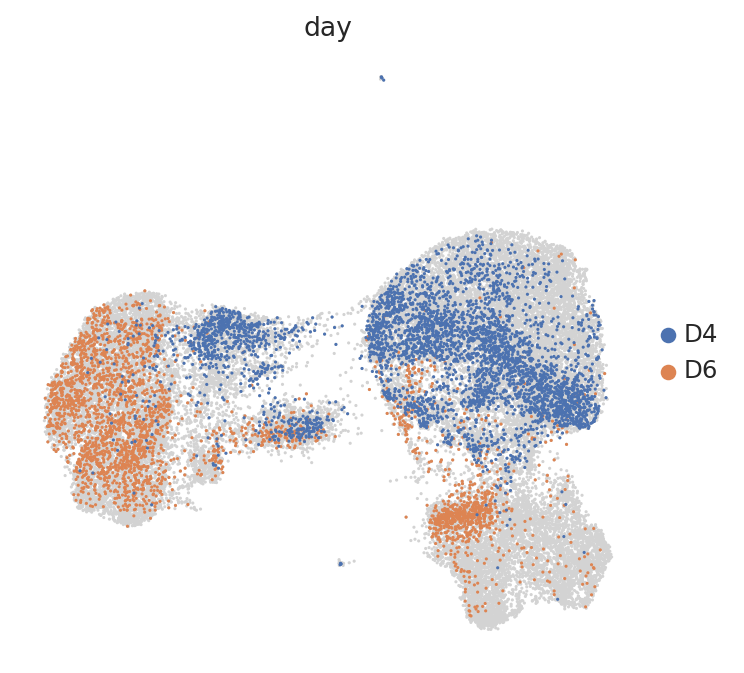

In [83]:
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(5,5)})

ax = sc.pl.umap(adata, size=8, show=False)
sc.pl.umap(
    adata[adata.obs.knockout == "Control"],
    size=8,
    color="day",
    ax=ax,
    show=False,
    frameon=False
)

plt.savefig("/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/umap_control.pdf")

/ix/djishnu/peasena/miniconda3/envs/mira-env/lib/python3.9/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


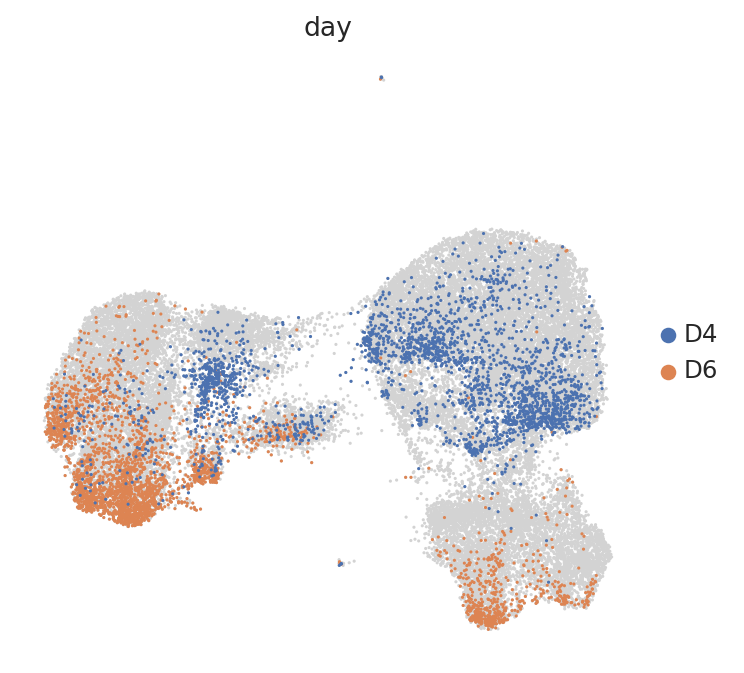

In [84]:
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(5,5)})

ax = sc.pl.umap(adata, size=8, show=False)
sc.pl.umap(
    adata[adata.obs.knockout == "BATF"],
    size=8,
    color="day",
    ax=ax,
    show=False,
    frameon=False
)

plt.savefig("/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/umap_batf.pdf")

/ix/djishnu/peasena/miniconda3/envs/mira-env/lib/python3.9/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


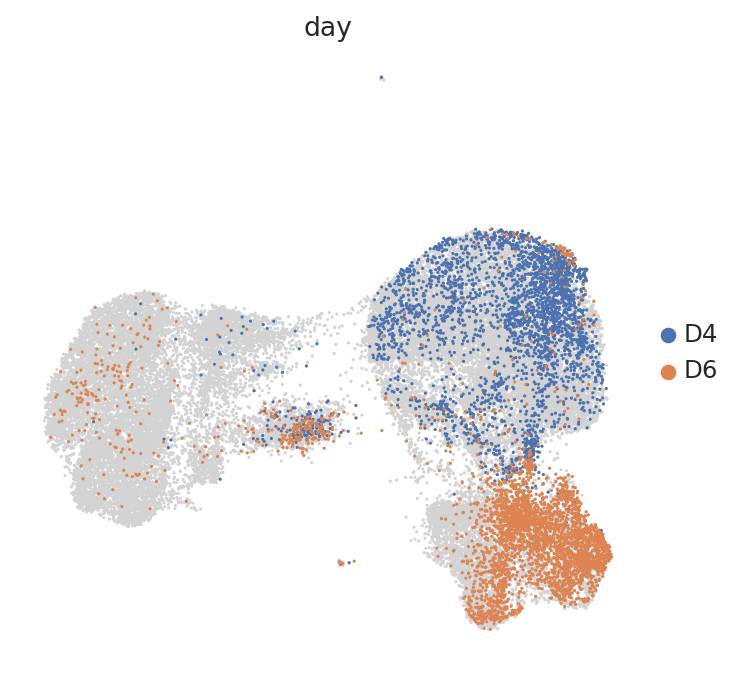

In [85]:
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(5,5)})

ax = sc.pl.umap(adata, size=8, show=False)
sc.pl.umap(
    adata[adata.obs.knockout == "IRF4"],
    size=8,
    color="day",
    ax=ax,
    show=False,
    frameon=False
)

plt.savefig("/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/umap_irf4.pdf")

/ix/djishnu/peasena/miniconda3/envs/mira-env/lib/python3.9/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


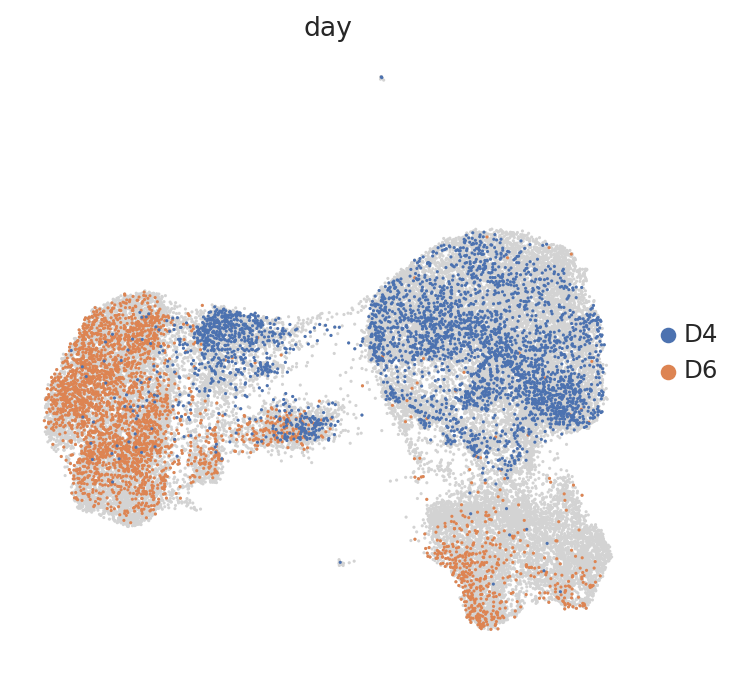

In [86]:
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(5,5)})

ax = sc.pl.umap(adata, size=8, show=False)
sc.pl.umap(
    adata[adata.obs.knockout == "IRF8" ],
    size=8,
    color="day",
    ax=ax,
    show=False,
    frameon=False
)

plt.savefig("/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/umap_irf8.pdf")

/ix/djishnu/peasena/miniconda3/envs/mira-env/lib/python3.9/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


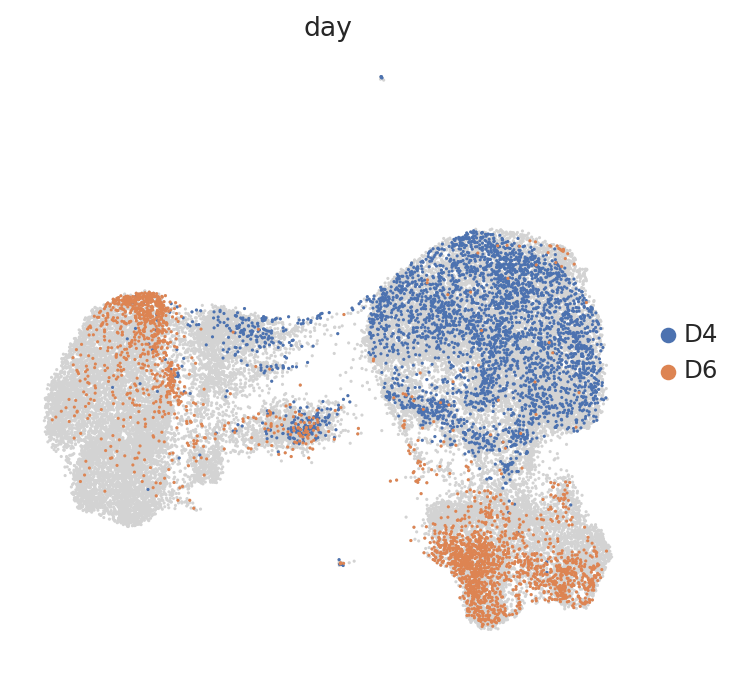

In [87]:
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(5,5)})

ax = sc.pl.umap(adata, size=8, show=False)
sc.pl.umap(
    adata[adata.obs.knockout == "PRDM1"],
    size=8,
    color="day",
    ax=ax,
    show=False,
    frameon=False
)

plt.savefig("/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/umap_prdm1.pdf")

In [88]:
adata.write('/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/gene_data_240729.merged_topics.h5ad')

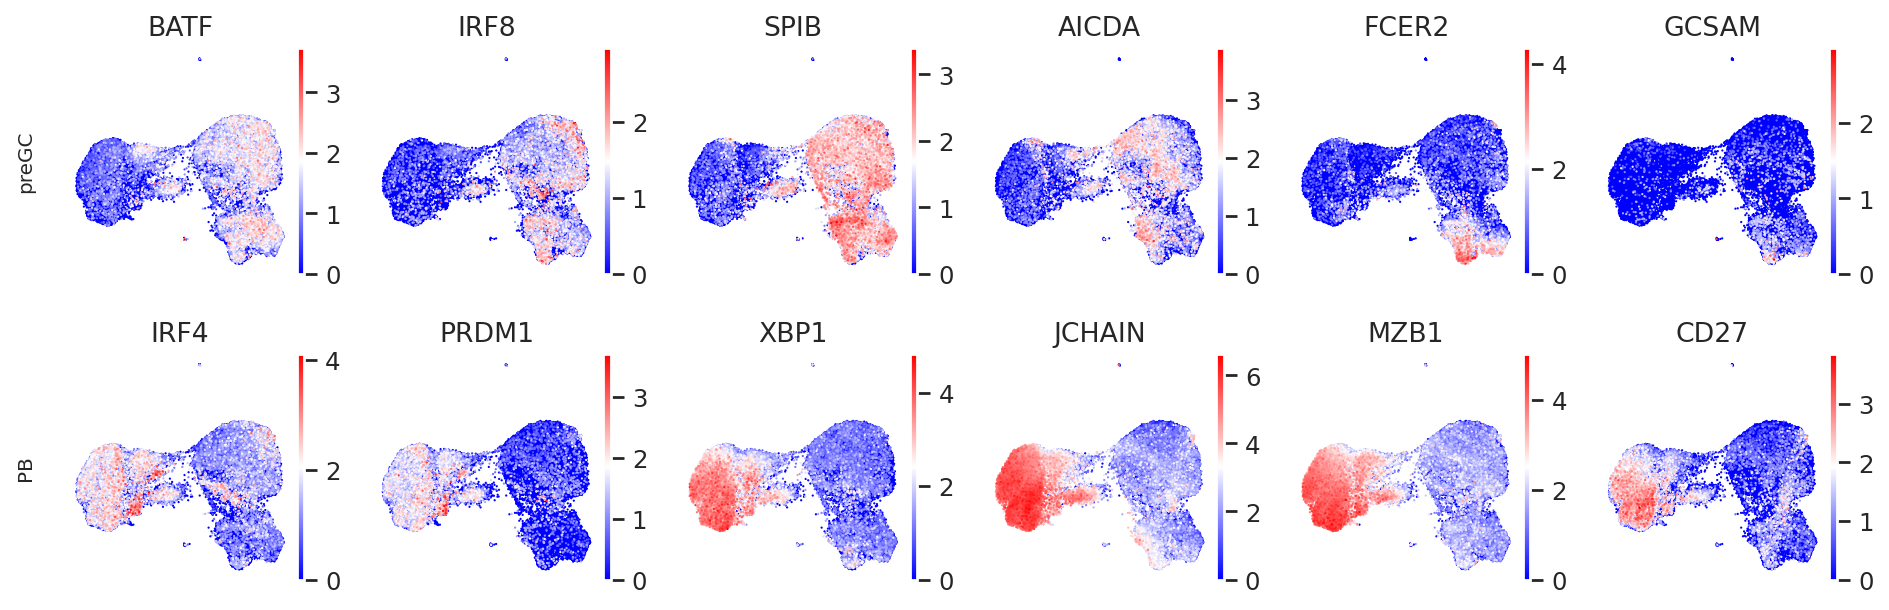

In [66]:
# In this example we want to show UMAPs of different cell type markers,
# with markers of a single cell type in one row
# and with a different number of markers per cell type (row)
sc.set_figure_params(scanpy=True, fontsize=14, dpi_save = 350)
sns.set(rc={'figure.figsize':(5,5)})


# Marker genes
marker_genes= {
    'preGC': ['BATF', 'IRF8','SPIB', 'AICDA', 'FCER2', 'GCSAM'],
    'PB': ['IRF4', 'PRDM1', 'XBP1', 'JCHAIN', 'MZB1', 'CD27',]
    #'Targeted TFs': ['BATF', 'IRF4', 'PRDM1', 'SPIB'],
    #'IL12': ['IL12A', 'IL12RB1', 'IL12RB2', 'STAT4'],
    #'IFNG': ['IFNG', 'IFNGR1', 'IFNGR2', 'IFNG-AS1', 'STAT1'],
    #'Inhibitors': ['SOCS1', 'SOCS3', 'CISH']
}
# Make Axes
# Number of needed rows and columns (based on the row with the most columns)
nrow=len(marker_genes)
ncol=max([len(vs) for vs in marker_genes.values()])
fig,axs=plt.subplots(nrow,ncol,figsize=(2*ncol,2*nrow))
# Plot expression for every marker on the corresponding Axes object
for row_idx,(cell_type,markers) in enumerate(marker_genes.items()):
    col_idx=0
    for marker in markers:
        ax=axs[row_idx,col_idx]
        sc.pl.umap(adata,color=marker,ax=ax,show=False,frameon=False,s=4, legend_fontsize = 2, cmap = 'bwr')
        # Add cell type as row label - here we simply add it as ylabel of
        # the first Axes object in the row
        if col_idx==0:
            # We disabled axis drawing in UMAP to have plots without background and border
            # so we need to re-enable axis to plot the ylabel
            ax.axis('on')
            ax.tick_params(
                top='off', bottom='off', left='off', right='off',
                labelleft='on', labelbottom='off')
            ax.set_ylabel(cell_type+'\n', rotation=90, fontsize=9)
            ax.set_xlabel('')
            ax.set(frame_on=False)
        col_idx+=1
    # Remove unused column Axes in the current row
    while col_idx<ncol:
        axs[row_idx,col_idx].remove()
        col_idx+=1
# Alignment within the Figure
fig.tight_layout()


plt.savefig("/ix/djishnu/peasena/tf_perturbseq/20231110_perturbseq1/results/umap_markers.pdf")